# Imports

In [698]:
import random 
import time
import numpy as np 
import matplotlib.pyplot as plt
from IPython.display import clear_output
from matplotlib.colors import LogNorm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from tqdm.notebook import tqdm

NUM_ROWS = 8
NUM_COLS = 25
SIDEWALK_LENGTH = NUM_ROWS * NUM_COLS # 8 rows, 25 cols
LITTER_CHANCE = .2
WALL_CHANCE = .2
NUM_ACTIONS = 4

FORWARD = 0
UP = 1
DOWN = 2
BACKWARDS = 3

NORMAL = "N"
OBSTACLE = "O"
LITTER = "L"

# World Rules

In [699]:
def gen_world():
  world = [NORMAL for _ in range(SIDEWALK_LENGTH)]
  for i in range(len(world)):
    row, col = state_to_coordinate(i)
    litter_decision = random.random()
    wall_decision = random.random()
    if LITTER_CHANCE > litter_decision:
      world[i] = LITTER
    elif WALL_CHANCE > wall_decision:
      world[i] = OBSTACLE
  return world
def move(state, action):
  row, col = state
  if action == 0: # right
    col += 1
  elif action == 1: # up
    row -= 1
  elif action == 2: # down
    row += 1
  elif action == 3: # left
    col -= 1
  return row, col

def get_legal_moves(state):
  cur_row, cur_col = state
  legal_moves = []
  for i in range(4):
    row, col = move(state, i)
    if row >= 0 and row < NUM_ROWS and col >= 0 and col < NUM_COLS:
      legal_moves.append(i)
  return legal_moves

def state_to_coordinate(state):
  return (int(state / NUM_COLS), state % NUM_COLS)
def manhattan_dist(state1, state2):
  return abs(state1[0]-state2[0]) + abs(state1[1]-state2[1])
def coordinate_to_state(coordinate):
  row, col = coordinate
  return int(row * NUM_COLS + col)

# Q-Learning Methods

In [700]:
def get_q_val_from_action(state, actions, modules):
    q_vals = []
    state_idx = coordinate_to_state(state)
    for action in actions:
      q_val = 0
      for module in modules:
        q_val += module.q_table[state_idx, action]
      q_vals.append(q_val)
    return q_vals

def steps(exploration_rate, state, modules):
  exploration_rate_threshold = random.uniform(0, 1)
  legal_moves = get_legal_moves(state)
  # Exploitation
  if exploration_rate_threshold > exploration_rate: 
    q_vals = get_q_val_from_action(state, legal_moves, modules)
    action = legal_moves[np.argmax(q_vals)]
  # Exploration
  else: 
    action_idx = random.randint(0, len(legal_moves)-1)
    action = legal_moves[action_idx]
  new_state = move(state, action)
  return new_state, action

def do_q_learning(num_trials, max_steps, learning_rate, discount_rate, explore_rate, max_explore_rate, min_explore_rate, explore_decay_rate, modules):
  rewards_all_trials = []
  for trial in tqdm(range(num_trials)):
      # print("_____TRIAL______")
      done = False
      reward_current_trial = 0
      step = 0
      state = (3,0)
      store_state = [coordinate_to_state(state)]
      while not done and step < max_steps: 
        new_state, action = steps(explore_rate, state, modules)
        reward = 0
        state_idx = coordinate_to_state(state)
        new_state_idx = coordinate_to_state(new_state)
        for module in modules:
          reward += module.get_reward(new_state, action)
          module.update_q_table(state_idx, action, new_state_idx, discount_rate, learning_rate, reward)
        # print(reward)
        state = new_state
        reward_current_trial += reward 
        store_state.append(new_state_idx)  
        if new_state[1] == NUM_COLS-1:
          done = True 
        step += 1
      # Exploration rate decay
      if explore_rate > 0:
        explore_rate = min_explore_rate + (max_explore_rate - min_explore_rate) * np.exp(-explore_decay_rate*trial)
      rewards_all_trials.append(reward_current_trial)
      for module in modules:
        module.refresh()


  return rewards_all_trials, store_state

def make_q_table(size, num_directions):
  q_table = np.zeros([size, num_directions])
  q_table[0:25, 1:2] = np.NINF
  q_table[175:200, 2:3] = np.NINF
  q_table[0:176:25, 3:] = np.NINF
  q_table[24:200:25, 0:1] = np.NINF
  return q_table

# Modular Q-Learning

In [701]:
def mod_get_q_val_from_action(state, actions, modules):
    q_vals = []
    state_idx = coordinate_to_state(state)
    for action in actions:
      q_val = []
      for module in modules:
        q_val.append(module.q_table[state_idx, action])
      q_vals.append(q_val)
    return np.array(q_vals)

def mod_steps(exploration_rate, state, modules, weights):
  exploration_rate_threshold = random.uniform(0, 1)
  legal_moves = get_legal_moves(state)
  # Exploitation
  if exploration_rate_threshold > exploration_rate:
    q_vals = mod_get_q_val_from_action(state, legal_moves, modules)
    q_vals = np.average(q_vals, axis=1, weights=weights)
    action = legal_moves[np.argmax(q_vals)]
  # Exploration
  else: 
    action_idx = random.randint(0, len(legal_moves)-1)
    action = legal_moves[action_idx]
  new_state = move(state, action)
  return new_state, action

def mod_do_q_learning(num_trials, max_steps, learning_rate, discount_rate, explore_rate, max_explore_rate, min_explore_rate, explore_decay_rate, modules, weights):
  rewards_all_trials = []
  for trial in tqdm(range(num_trials)):
    if trial != 0 and trial % 10 == 0:
      for module in modules:
        module.normalize_q_table()
    # print("_____TRIAL______")
    done = False
    reward_current_trial = 0
    step = 0
    state = (3,0)
    store_state = [coordinate_to_state(state)]
    while not done and step < max_steps: 
      new_state, action = mod_steps(explore_rate, state, modules, weights)
      reward = 0
      state_idx = coordinate_to_state(state)
      new_state_idx = coordinate_to_state(new_state)
      for module in modules:
        reward += module.get_reward(new_state, action)
        module.update_q_table(state_idx, action, new_state_idx, discount_rate, learning_rate, reward)
      # print(reward)
      state = new_state
      reward_current_trial += reward 
      store_state.append(new_state_idx)  
      if new_state[1] == NUM_COLS-1:
        done = True 
      step += 1
    # Exploration rate decay
    rewards_all_trials.append(reward_current_trial)
    if explore_rate > 0:
      explore_rate = min_explore_rate + (max_explore_rate - min_explore_rate) * np.exp(-explore_decay_rate*trial)
    for module in modules:
      module.refresh()
  return rewards_all_trials, store_state


# Visualization

In [702]:

def draw_grid(img, grid_shape, width, color=(0, 255, 0), show_background=True):
    h, w, _ = img.shape
    rows, cols = grid_shape
    dy, dx = h / rows, w / cols
    # draw vertical lines
    if show_background: 
      cv2.rectangle(img, (0, width), (img.shape[1], img.shape[0]-width), (105, 105, 105), -1)
    for x in np.linspace(start=dx, stop=w-dx, num=cols-1):
        x = int(round(x))
        cv2.line(img, (x, 0), (x, h), color=color, thickness=1)
    # draw horizontal lines
    for y in np.linspace(start=dy, stop=h-dy, num=rows-1):
        y = int(round(y))
        cv2.line(img, (0, y), (w, y), color=color, thickness=1)
          # Python program to explain cv2.circle() method
    return img
def draw_circle(img, states, width):
  prev_point = None
  for state in states:
    row, col = state_to_coordinate(state)
    end_point = (col * width + int(width/2), row * width + int(width/2))
    if prev_point != None:
      cv2.arrowedLine(img, prev_point, end_point, (0,0,255), 2, tipLength=0.2)
    prev_point = end_point

  return img
def draw_litter_and_obstacles(img, width, litter, obstacles):
  for trash in litter:
    row, col = state_to_coordinate(trash)
    cv2.rectangle(img, (col*width+20, row*width+20), (col*width+width-20, row*width+width-20), (128, 0, 128), -1)
  for obstacle in obstacles:
    row, col = state_to_coordinate(obstacle)
    cv2.rectangle(img, (col*width+20, row*width+20), (col*width+width-20, row*width+width-20), (255, 0, 0), -1)
  return img

def show_sidewalk(states, litter, obstacles, width=100, show_background=True):
  canvas = np.zeros((NUM_ROWS*width, NUM_COLS*width, 3), dtype="uint8")
  # draw a green line from the top-left corner of our canvas to the
  # bottom-right
  cv2.waitKey(0)
  canvas = draw_grid(canvas, (NUM_ROWS, NUM_COLS), width, show_background=show_background)
  canvas = draw_litter_and_obstacles(canvas, width, litter, obstacles)
  canvas = draw_circle(canvas, states, width)

  # canvas = draw_rewards(canvas, width, sidewalk)
  cv2_imshow(canvas)
  cv2.waitKey(0)
# # def draw_rewards(img, width):
# #   fontScale = 1
# #   color = (255, 255, 255)
# #   font = cv2.FONT_HERSHEY_COMPLEX_SMALL
# #   thickness = 1
# #   for i in range((NUM_ROWS*NUM_COLS)):
# #     row, col = state_to_coordinate(i)
# #     # text = str(sidewalk[row][col])
# #     org = (int(col*width+width/4), int(row*width+width/2))
# #     # Using cv2.putText() method
# #     cv2.putText(img, text, org, font, fontScale, 
# #                     color, thickness, cv2.LINE_AA, False)
#   return img

# Module Classes

In [703]:
class RL_Module():
  def __init__(self, world):
    self.world = world
  def refresh(self):
    pass
  def set_q_table(self, q_table):
    self.q_table = q_table
  def update_q_table(self, state_idx, action, new_state_idx, discount_rate, learning_rate, reward):
    self.q_table[state_idx, action] = self.q_table[state_idx, action] * (1 - learning_rate) + learning_rate * (reward + discount_rate * np.max(self.q_table[new_state_idx, :]))
  def normalize_q_table(self):
    sum = 0
    for row in range(len(self.q_table)):
      for col in range(len(self.q_table[row])):
        if self.q_table[row, col] != np.NINF:
          sum += self.q_table[row, col]
    for row in range(len(self.q_table)):
      for col in range(len(self.q_table[row])):
        if self.q_table[row, col] != np.NINF:
          self.q_table[row, col] /= sum

class Center_Module(RL_Module):
  def __init__(self, world, reward, penalty):
    super().__init__(world)
    self.reward = reward
    self.penalty = penalty
  def get_reward(self, state, action):
    row, col = state
    if row == 0 or row == NUM_ROWS - 1:
      return self.penalty
    else:
      return self.reward

class Litter_Module(RL_Module):
  def __init__(self, world, reward, penalty):
    super().__init__(world)
    self.reward = reward
    self.penalty = penalty
    self.litter_map = world.copy()
  def get_reward(self, state, action):
    state_idx = coordinate_to_state(state)
    val = self.penalty
    if self.litter_map[state_idx] == LITTER:
      val = self.reward
      self.litter_map[state_idx] = NORMAL
    return val
  def refresh(self):
    self.litter_map = self.world.copy()
    

class Obstacle_Module(RL_Module):
    def __init__(self, world, penalty):
        super().__init__(world)
        self.penalty = penalty
    def get_reward(self, state, action):
        state_idx = coordinate_to_state(state)
        if self.world[state_idx] == OBSTACLE:
            return self.penalty
        else:
            return 0.0  
class Forward_Module(RL_Module):
    def __init__(self, world, back_penalty, side_penalty, reward):
        super().__init__(world)
        self.back_penalty = back_penalty
        self.side_penalty = side_penalty
        self.reward = reward
    def get_reward(self, state, action):
      row, col = state
      if col == NUM_COLS-1:
          return self.reward
      if action == BACKWARDS:
          return self.back_penalty
      else:
          return self.side_penalty

# Generate World

In [704]:
# world = gen_world()

# dont uncomment unless you want to use a new world
world = ['N','N','N','L','N','L','O','N','N','N','N','L','L','O','N','O','N','N','N','N','N','L','N','N','N', 
         'O','N','N','N','N','N','O','N','N','L','L','O','N','N','L','N','N','N','N','N','N','L','N','L','N',
         'N','N','L','L','N','N','N','N','N','N','N','N','N','N','N','O','N','O','L','L','L','N','N','N','N',
         'N','N','N','N','N','L','N','L','N','N','N','N','O','N','N','L','O','L','N','N','N','N','L','N','L',
         'L','L','N','N','L','N','N','N','N','N','N','N','N','N','N','N','L','N','N','N','N','N','N','N','N', 
         'N','N','O','L','N','N','L','L','O','O','L','L','O','N','L','N','O','N','N','N','L','N','L','N','N',
         'N','O','N','L','L','N','N','N','N','N','O','O','O','N','L','N','N','O','N','N','N','N','O','N','N',
         'N','O','N','N','N','N','N','N','L','N','N','L','N','N','L','N','N','N','N','N','O','N','L','L','N']

litter = [index for index, element in enumerate(world) if element == LITTER]
obstacles = [index for index, element in enumerate(world) if element == OBSTACLE]

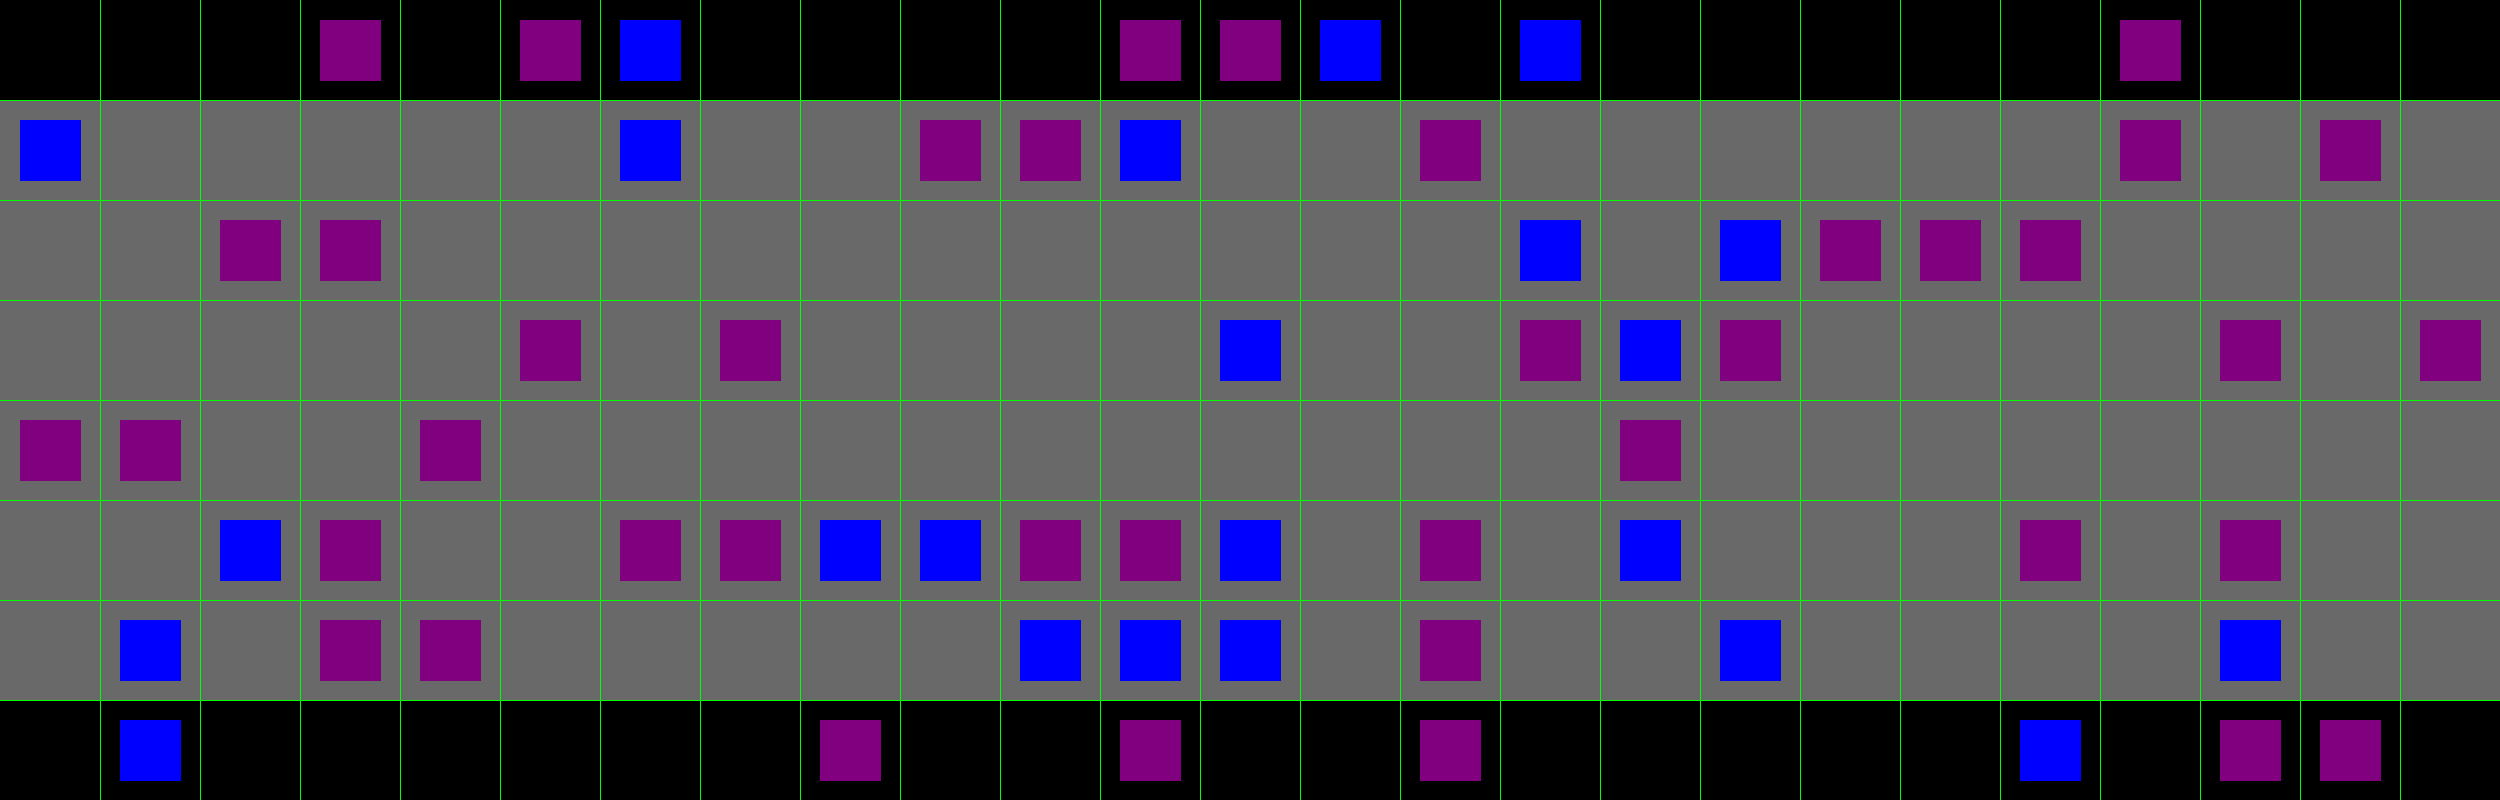

['N', 'N', 'N', 'L', 'N', 'L', 'O', 'N', 'N', 'N', 'N', 'L', 'L', 'O', 'N', 'O', 'N', 'N', 'N', 'N', 'N', 'L', 'N', 'N', 'N', 'O', 'N', 'N', 'N', 'N', 'N', 'O', 'N', 'N', 'L', 'L', 'O', 'N', 'N', 'L', 'N', 'N', 'N', 'N', 'N', 'N', 'L', 'N', 'L', 'N', 'N', 'N', 'L', 'L', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'O', 'N', 'O', 'L', 'L', 'L', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'L', 'N', 'L', 'N', 'N', 'N', 'N', 'O', 'N', 'N', 'L', 'O', 'L', 'N', 'N', 'N', 'N', 'L', 'N', 'L', 'L', 'L', 'N', 'N', 'L', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'L', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'O', 'L', 'N', 'N', 'L', 'L', 'O', 'O', 'L', 'L', 'O', 'N', 'L', 'N', 'O', 'N', 'N', 'N', 'L', 'N', 'L', 'N', 'N', 'N', 'O', 'N', 'L', 'L', 'N', 'N', 'N', 'N', 'N', 'O', 'O', 'O', 'N', 'L', 'N', 'N', 'O', 'N', 'N', 'N', 'N', 'O', 'N', 'N', 'N', 'O', 'N', 'N', 'N', 'N', 'N', 'N', 'L', 'N', 'N', 'L', 'N', 'N', 'L', 'N', 'N', 'N', 'N', 'N', 'O', 'N', 'L', 'L', 'N']

In [705]:
show_sidewalk([], litter, obstacles)
print(world)

# Move Forward Module

  0%|          | 0/10000 [00:00<?, ?it/s]

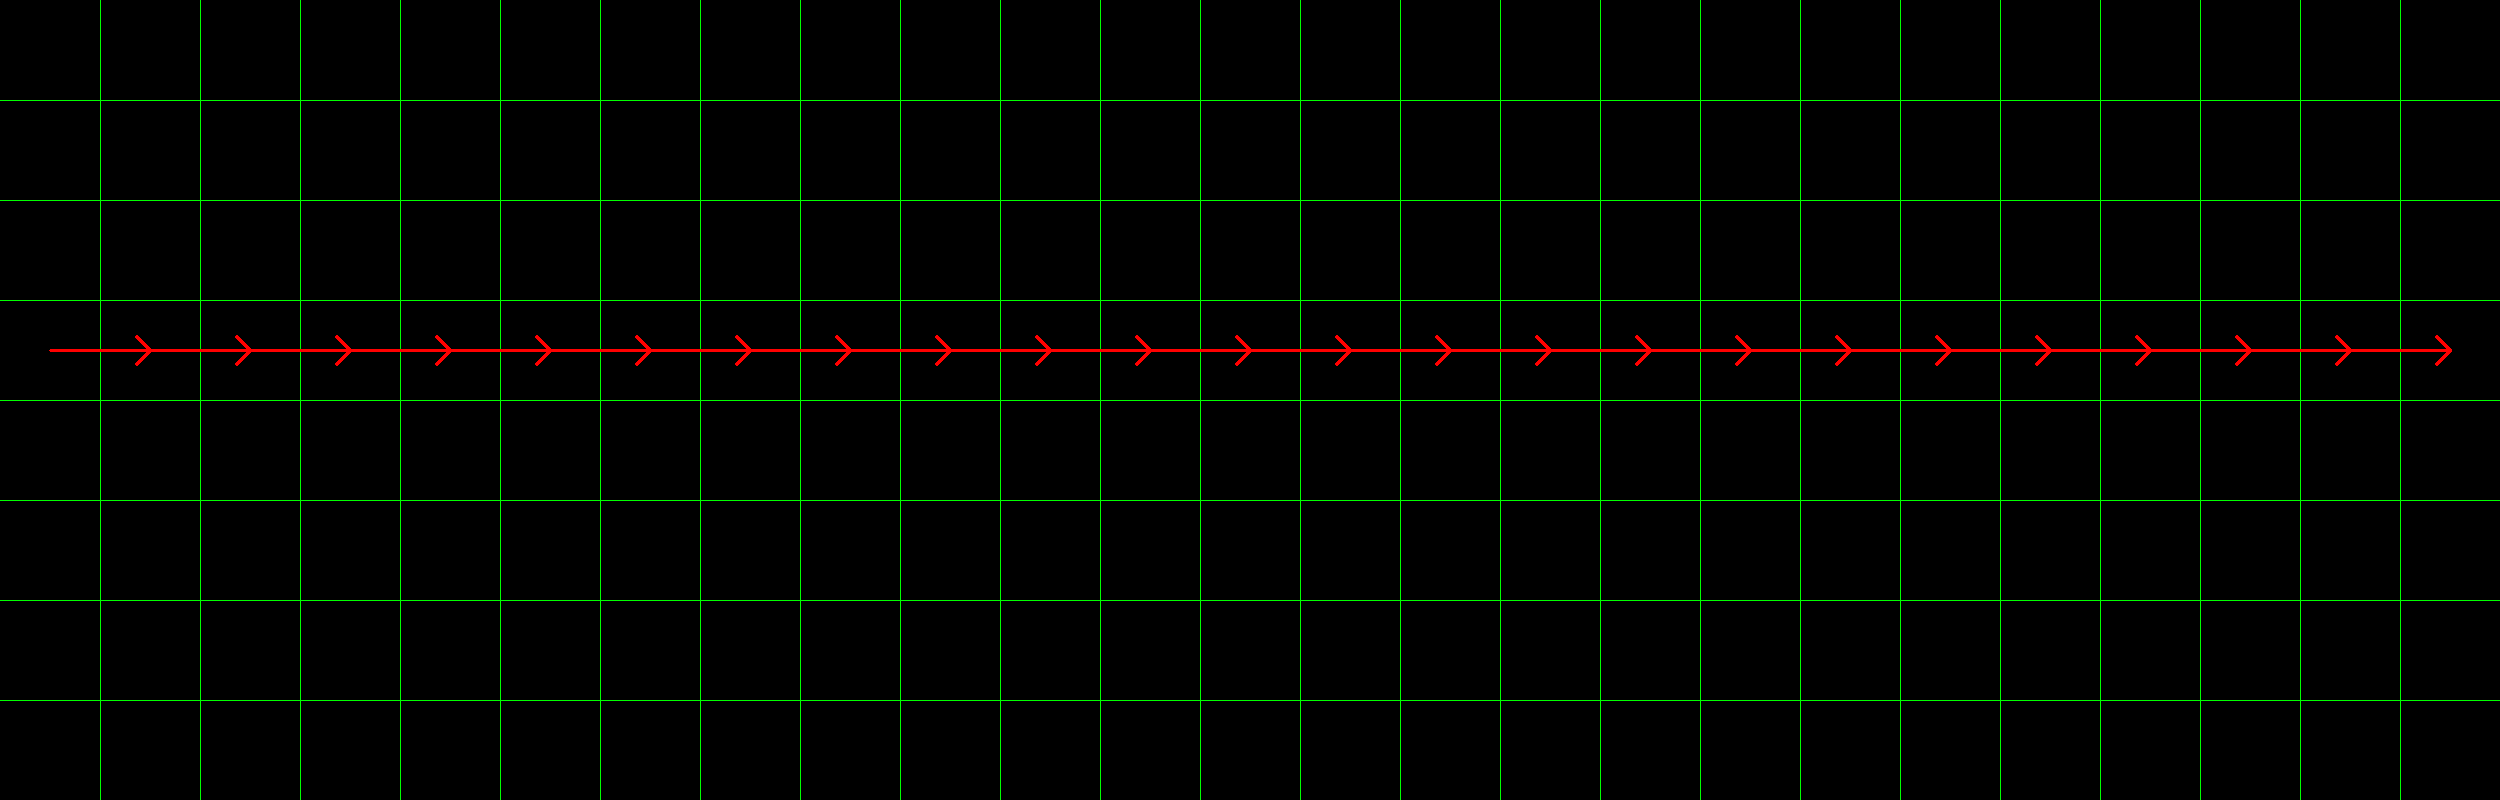

In [706]:
forward_module = Forward_Module(world, -2.0, -1.0, 20.0)
# Place Litter and Walls
total_trials = 10000
max_steps_per_episode = 200

learning_rate = 0.9
discount_rate = 0.3

# exploration_rate = min_explore_rate + (max_explore_rate - min_explore_rate) * np.exp(-explore_decay_rate*trial)
exploration_rate =  1.0
max_exploration_rate = 1.0
min_exploration_rate = 0.001
exploration_decay_rate = 0.001

actions = 4
modules = [forward_module]
# Make Qmap
forward_q_table = make_q_table(200, 4)
forward_module.set_q_table(forward_q_table)
rewards, path = do_q_learning(
    total_trials, 
    max_steps_per_episode, 
    learning_rate, 
    discount_rate, 
    exploration_rate, 
    max_exploration_rate,
    min_exploration_rate, 
    exploration_decay_rate, 
    modules)
show_sidewalk(path, [], [], show_background=False)

# Obstacle Module

  0%|          | 0/10000 [00:00<?, ?it/s]

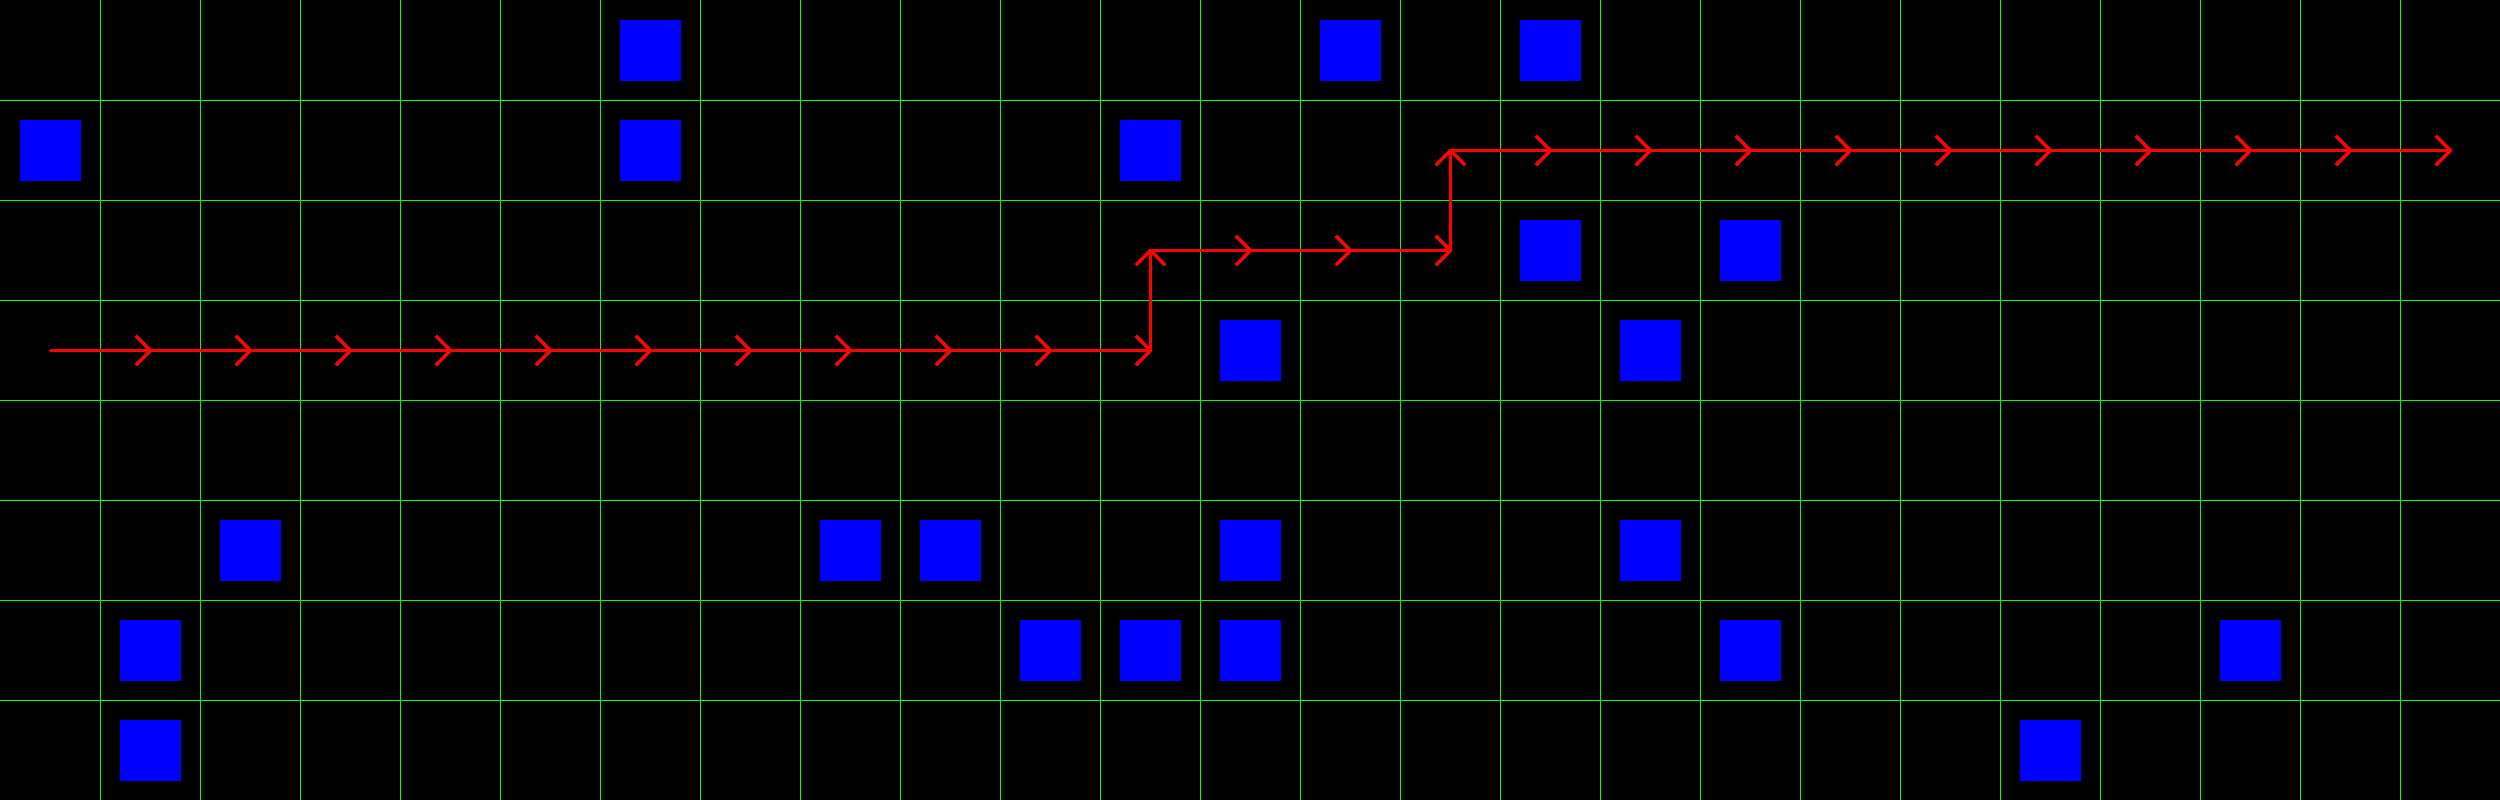

[-165.0, -150.0, -345.0, -180.0, -255.0, -315.0, -420.0, -240.0, -300.0, -255.0, -345.0, -435.0, -270.0, -240.0, -180.0, -315.0, -165.0, -315.0, -435.0, -165.0, -135.0, -195.0, -135.0, -345.0, -285.0, -495.0, -585.0, -270.0, -300.0, -420.0, -450.0, -270.0, -195.0, -495.0, -255.0, -315.0, -480.0, -330.0, -540.0, -315.0, -315.0, -360.0, -240.0, -285.0, -360.0, -375.0, -315.0, -315.0, -495.0, -300.0, -195.0, -195.0, -345.0, -210.0, -435.0, -270.0, -450.0, -195.0, -225.0, -240.0, -285.0, -240.0, -315.0, -270.0, -390.0, -180.0, -255.0, -375.0, -255.0, -240.0, -540.0, -285.0, -150.0, -330.0, -315.0, -555.0, -300.0, -480.0, -255.0, -405.0, -300.0, -225.0, -390.0, -450.0, -285.0, -195.0, -240.0, -165.0, -465.0, -300.0, -135.0, -285.0, -165.0, -240.0, -420.0, -75.0, -285.0, -180.0, -420.0, -315.0, -195.0, -330.0, -315.0, -285.0, -315.0, -345.0, -165.0, -255.0, -405.0, -105.0, -270.0, -405.0, -390.0, -345.0, -195.0, -285.0, -225.0, -195.0, -105.0, -240.0, -180.0, -75.0, -270.0, -180.0, -375.0, -

In [707]:
obstacle_module = Obstacle_Module(world, -15.0)

# Place Litter and Walls
total_trials = 10000
max_steps_per_episode = 200

learning_rate = 0.2
discount_rate = 0.1

# exploration_rate = min_explore_rate + (max_explore_rate - min_explore_rate) * np.exp(-explore_decay_rate*trial)
exploration_rate =  1.0
max_exploration_rate = 1.0
min_exploration_rate = 0.001
exploration_decay_rate = 0.001

actions = 4
modules = [obstacle_module]
# Make Qmap
obstacle_q_table = make_q_table(200, 4)
obstacle_module.set_q_table(obstacle_q_table)
rewards, path = do_q_learning(
    total_trials, 
    max_steps_per_episode, 
    learning_rate, 
    discount_rate, 
    exploration_rate, 
    max_exploration_rate,
    min_exploration_rate, 
    exploration_decay_rate, 
    modules)
show_sidewalk(path, [], obstacles, show_background=False)
print(rewards)
print(rewards[-1])

# Litter module

  0%|          | 0/10000 [00:00<?, ?it/s]

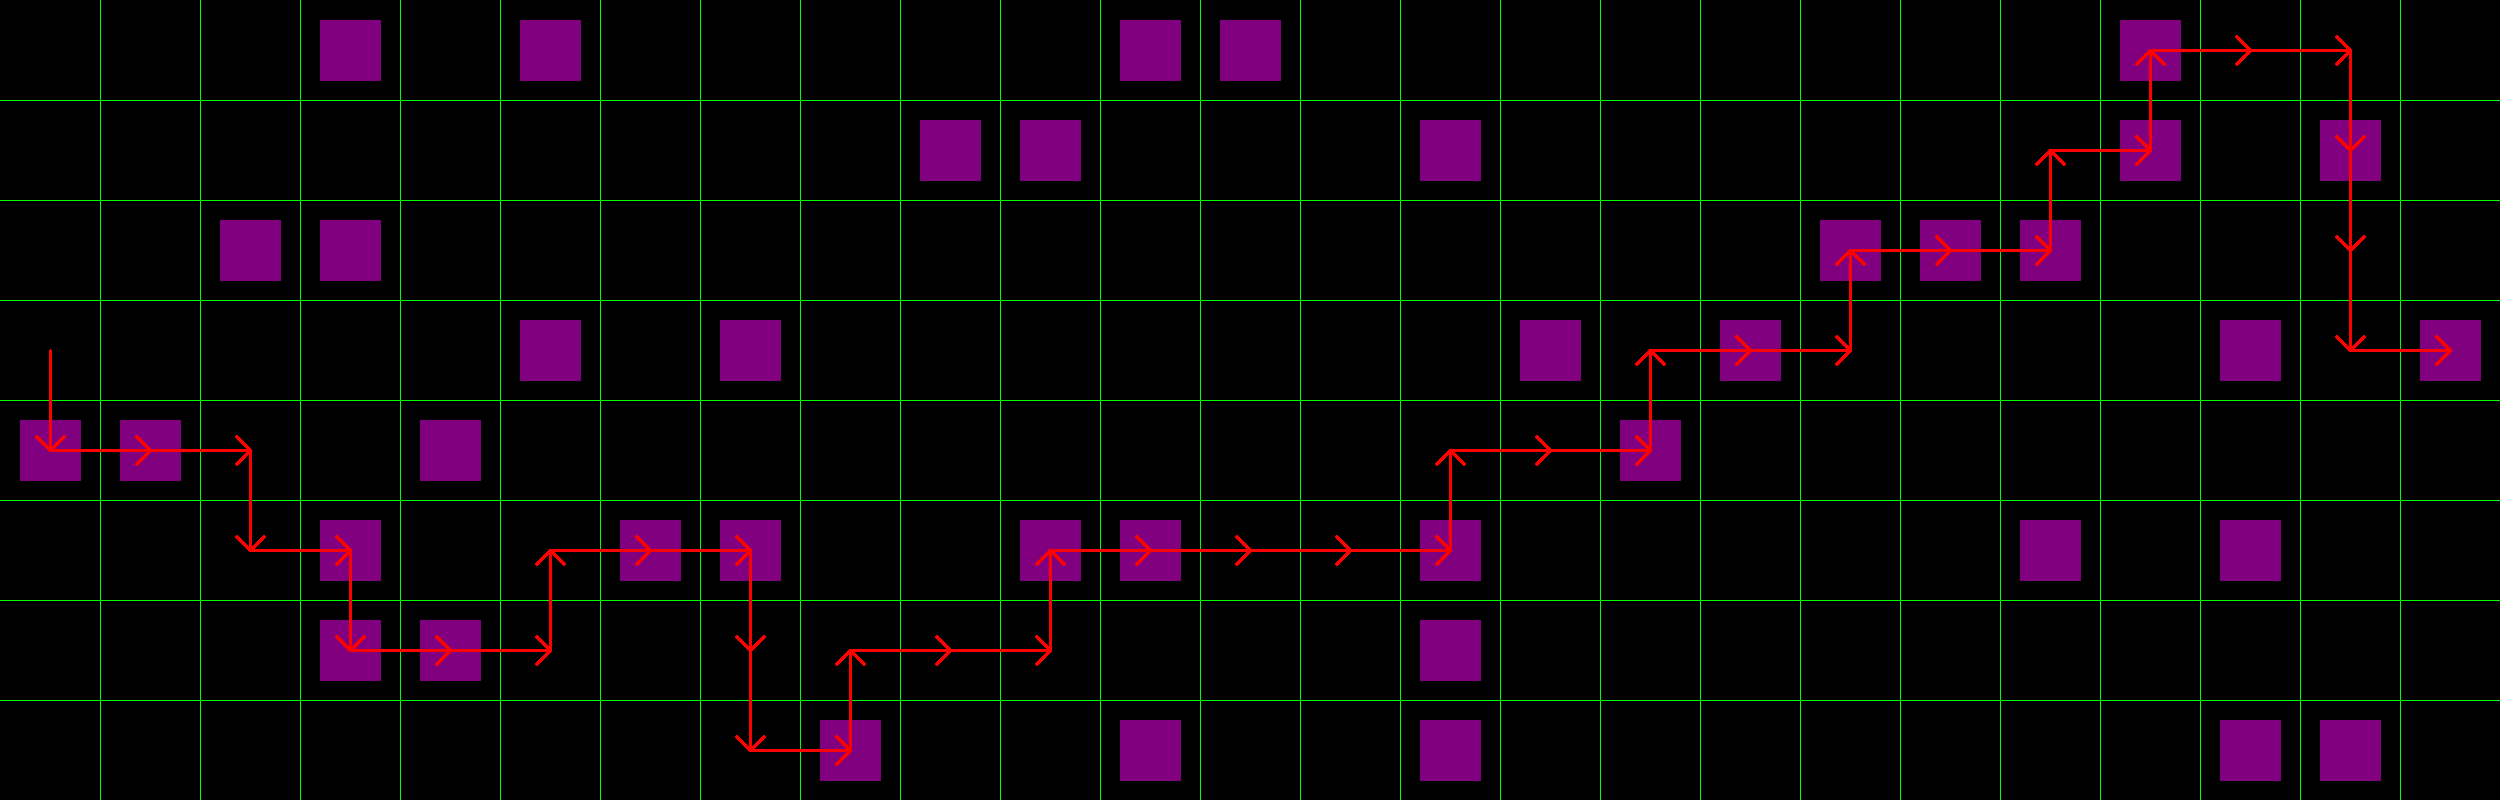

In [708]:
litter_module = Litter_Module(world, 75.0, 0.0)
# Place Litter and Walls
total_trials = 10000
max_steps_per_episode = 200

learning_rate = 0.8
discount_rate = 0.001

# exploration_rate = min_explore_rate + (max_explore_rate - min_explore_rate) * np.exp(-explore_decay_rate*trial)
exploration_rate =  1.0
max_exploration_rate = 1.0
min_exploration_rate = 0.001
exploration_decay_rate = 0.001

actions = 4
modules = [litter_module]
# Make Qmap
litter_q_table = make_q_table(200, 4)
litter_module.set_q_table(litter_q_table)
rewards, path = do_q_learning(
    total_trials, 
    max_steps_per_episode, 
    learning_rate, 
    discount_rate, 
    exploration_rate, 
    max_exploration_rate,
    min_exploration_rate, 
    exploration_decay_rate, 
    modules)
show_sidewalk(path, litter, [], show_background=False)

In [709]:
print(len(litter))

41


# Center Module

  0%|          | 0/1000 [00:00<?, ?it/s]

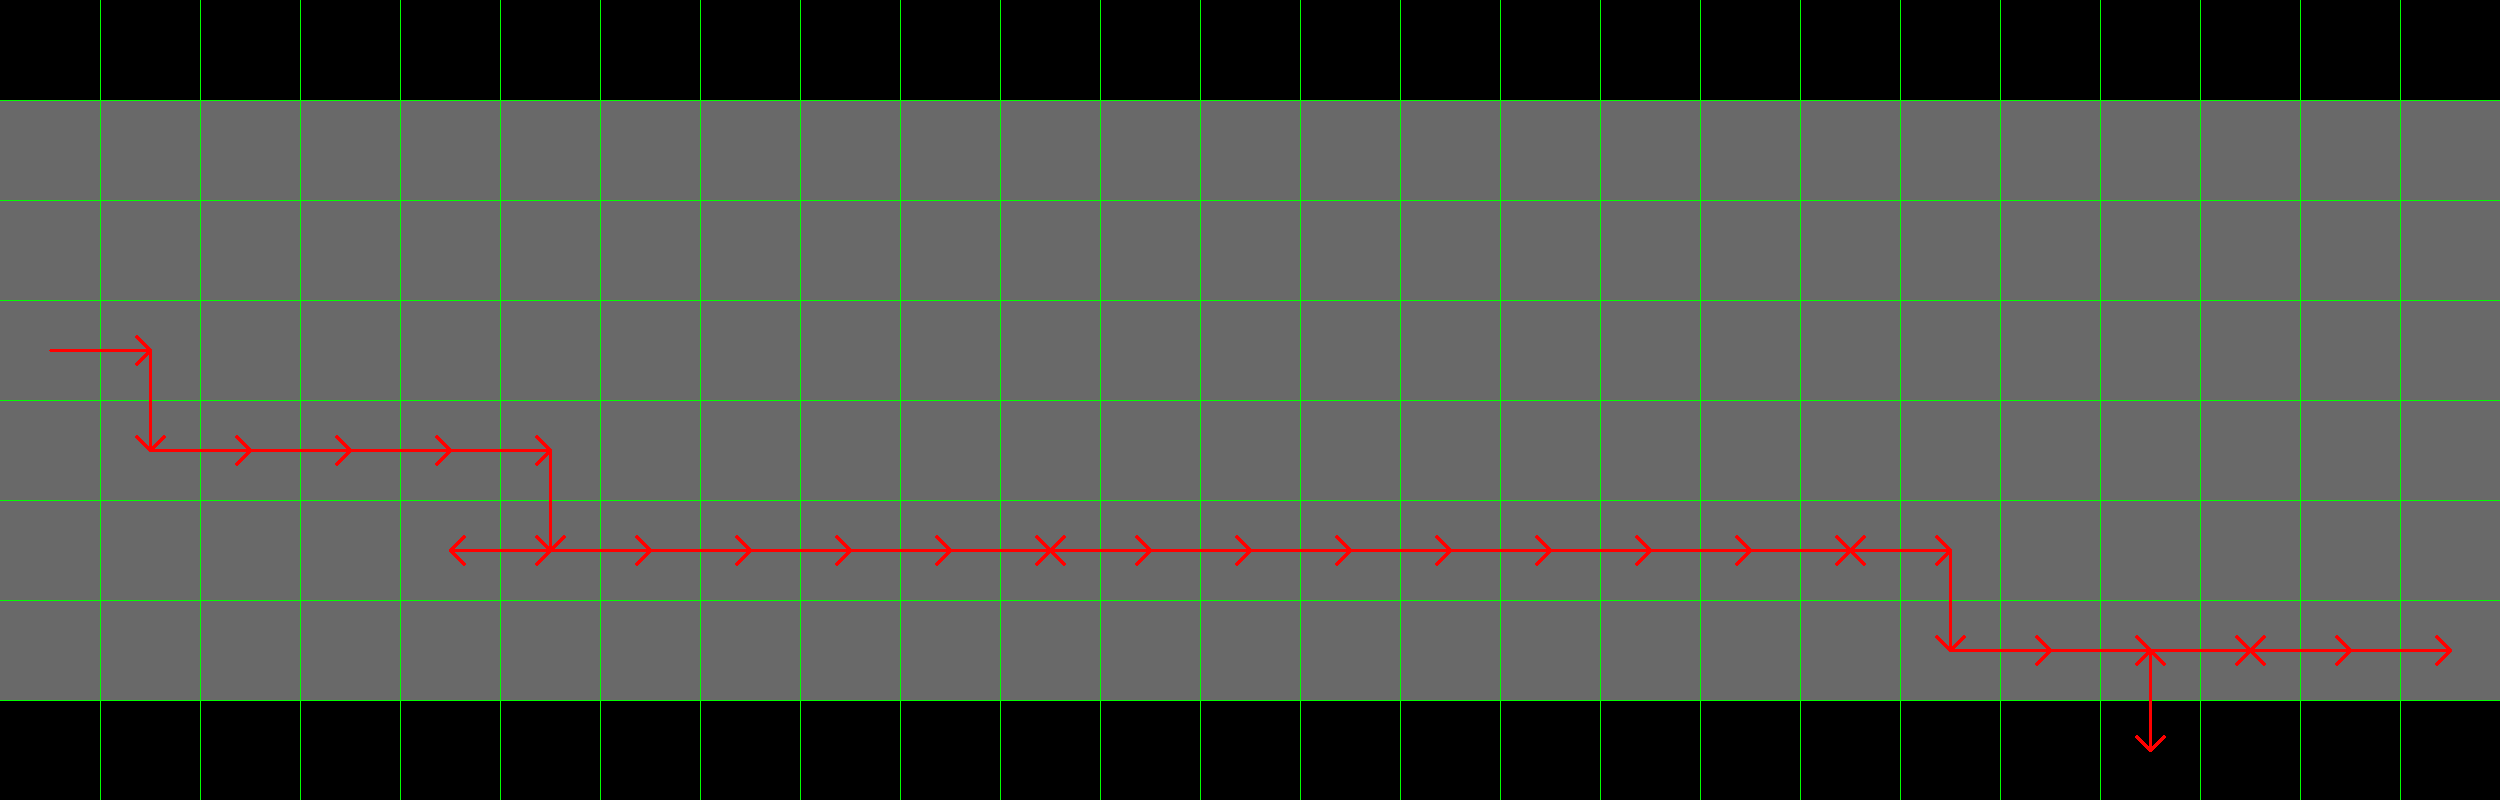

In [710]:
center_module = Center_Module(world, 0.0, -100.0)
# Place Litter and Walls
total_trials = 1000
max_steps_per_episode = 200

learning_rate = 0.9
discount_rate = 0.5

# exploration_rate = min_explore_rate + (max_explore_rate - min_explore_rate) * np.exp(-explore_decay_rate*trial)
exploration_rate =  1.0
max_exploration_rate = 1.0
min_exploration_rate = 0.001
exploration_decay_rate = 0.001

actions = 4
modules = [center_module]
# Make Qmap
center_q_table = make_q_table(200, 4)
center_module.set_q_table(center_q_table)
rewards, path = do_q_learning(
    total_trials, 
    max_steps_per_episode, 
    learning_rate, 
    discount_rate, 
    exploration_rate, 
    max_exploration_rate,
    min_exploration_rate, 
    exploration_decay_rate, 
    modules)
show_sidewalk(path, [], [])

# Combo Module

  0%|          | 0/1 [00:00<?, ?it/s]

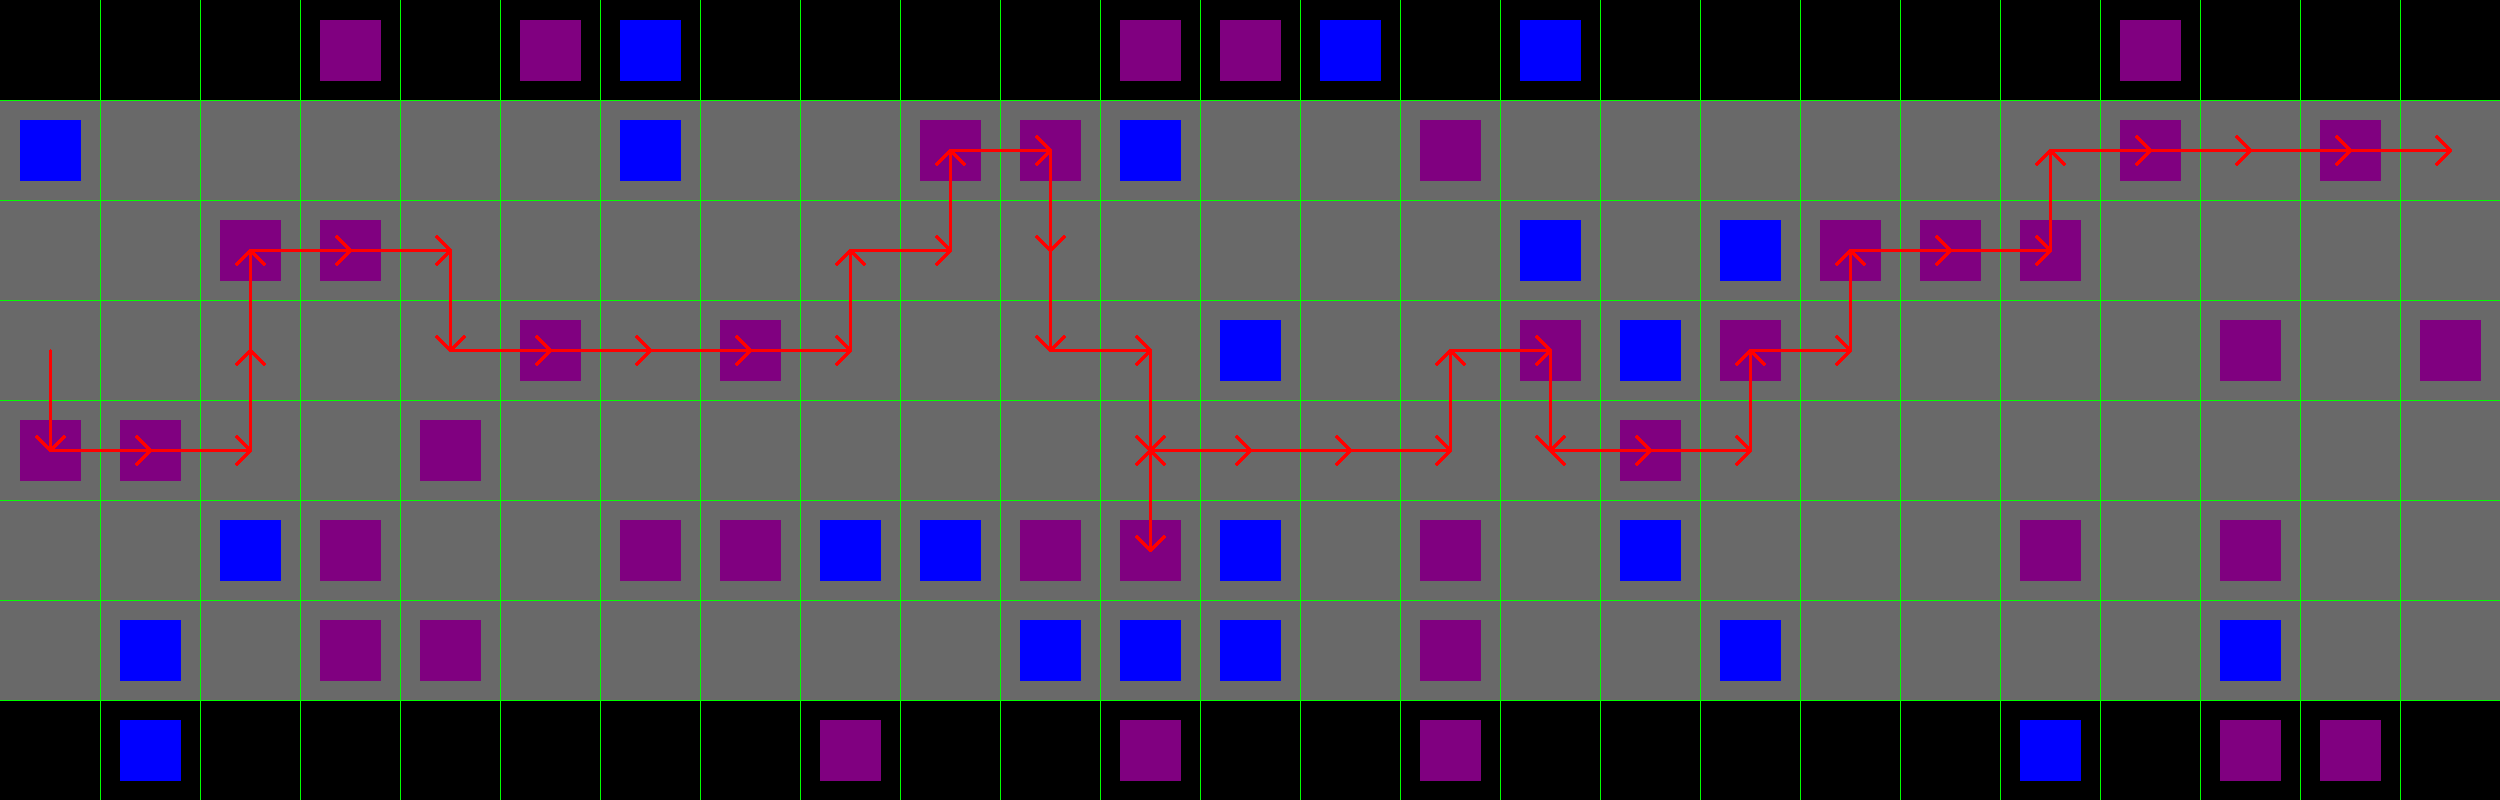

[1235.0]
1235.0
[75, 100, 101, 102, 77, 52, 53, 54, 79, 80, 81, 82, 83, 58, 59, 34, 35, 60, 85, 86, 111, 136, 111, 136, 111, 136, 111, 136, 111, 136, 111, 136, 111, 136, 111, 136, 111, 136, 111, 136, 111, 112, 113, 114, 89, 90, 115, 116, 115, 116, 117, 92, 93, 68, 69, 70, 45, 46, 47, 48, 49]


In [718]:
# Place Litter and Walls
total_trials = 1000
max_steps_per_episode = 200

learning_rate = 0.5
discount_rate = 0.01

# exploration_rate = min_explore_rate + (max_explore_rate - min_explore_rate) * np.exp(-explore_decay_rate*trial)
exploration_rate =  -1.0
max_exploration_rate = 1.0
min_exploration_rate = 0.001
exploration_decay_rate = 0.001

modules = [forward_module, obstacle_module, center_module, litter_module]
weights = [1.25, 0.5, 0.5, 1.25]
actions = 4
# modules = [litter_module]
# Make Qmap
rewards, path = mod_do_q_learning(
    total_trials, 
    max_steps_per_episode, 
    learning_rate, 
    discount_rate, 
    exploration_rate, 
    max_exploration_rate,
    min_exploration_rate, 
    exploration_decay_rate, 
    modules, 
    weights)
show_sidewalk(path, litter, obstacles)
print(rewards)
print(rewards[-1])
print(path)

# Stuff that didnt work

In [ ]:
def center_module_world(center_reward=0.0, penalty=-1.0):
  state = np.zeros(SIDEWALK_LENGTH)
  state = np.reshape(state, (8, 25))
  num_rows = int(state.shape[0])
  num_cols = int(state.shape[1])
  state[1:-1] = center_reward
  state[0][:] = penalty
  state[-1][:] = penalty
  return state
def forward_module_world():
  state = np.zeros(SIDEWALK_LENGTH)
  state = np.reshape(state, (8, 25))
  state[:] = np.linspace(0, 3, 25)
  print(state)
  return state
def obstacle_module_world(penalty, obstacles):
  state = np.zeros(SIDEWALK_LENGTH)
  state[:] = 0.1
  state = np.reshape(state, (8, 25))
  for obstacle in obstacles:
    row, col = state_to_coordinate(sidewalk, obstacle)
    state[row][col] = penalty
  return state
def litter_module_world(reward, flat_value, litter):
  state = np.zeros(SIDEWALK_LENGTH)
  state[:] = flat_value
  state = np.reshape(state, (8, 25))
  for trash in litter:
    row, col = state_to_coordinate(sidewalk, trash)
    state[row][col] = reward
  return state